In [23]:
import duckdb 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)
path = "/home/etienne/projects/obsq/work/dev/data/data.duckdb"
target = 'expert_match'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
table = 'combined'
schema = 'features'
con = duckdb.connect(path)
df = con.execute(f"""SELECT* FROM {schema}.{table}""" ).df()
#df = df.drop(columns= 'geom')
con.close()

In [11]:
cols_to_remove = ['tempo_eventDate']
cols_to_remove.append(target)
cols_to_remove.append('gbifID')

In [18]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'average_precision': 'average_precision'  # Better for imbalanced data
}

In [15]:
X = df.drop(columns=cols_to_remove)
y = df[target]


In [ ]:
X.head()

,obsv_obs_count,obsv_total_pct,obsv_expert_ids,obsv_expert_ids_pct,obsv_expert_match_count,obsv_expert_match_pct,obsv_avg_id_time,obsv_class_count,obsv_order_count,obsv_family_count,...,cmva_expert_id,tempo_day,tempo_month,tempo_year,meta_media_count,meta_coordinateUncertaintyInMeters,meta_pheno_01,meta_pheno_02,meta_pheno_03,meta_occurrenceRemarks
0,163,0.00410,1,0.00600,1,0.00610,0.00000,4,20,32,...,0,9,4,2025,90,20,0,1,0,0
1,163,0.00410,1,0.00600,1,0.00610,0.00000,4,20,32,...,0,9,4,2025,50,20,1,1,0,60
2,163,0.00410,1,0.00600,1,0.00610,0.00000,4,20,32,...,0,9,4,2025,60,20,1,1,0,0
3,163,0.00410,1,0.00600,1,0.00610,0.00000,4,20,32,...,0,9,4,2025,80,20,1,1,0,0
4,163,0.00410,1,0.00600,1,0.00610,0.00000,4,20,32,...,0,9,4,2025,60,20,1,1,0,58


In [29]:
#Define model params
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',  # Handle imbalance
    random_state=42,
    n_jobs=-1
)

In [ ]:
#Define model params
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

In [40]:
#Fit model
model.fit(X, y)



,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsam

In [36]:
#Feature importance
importances = model.feature_importances_
    
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

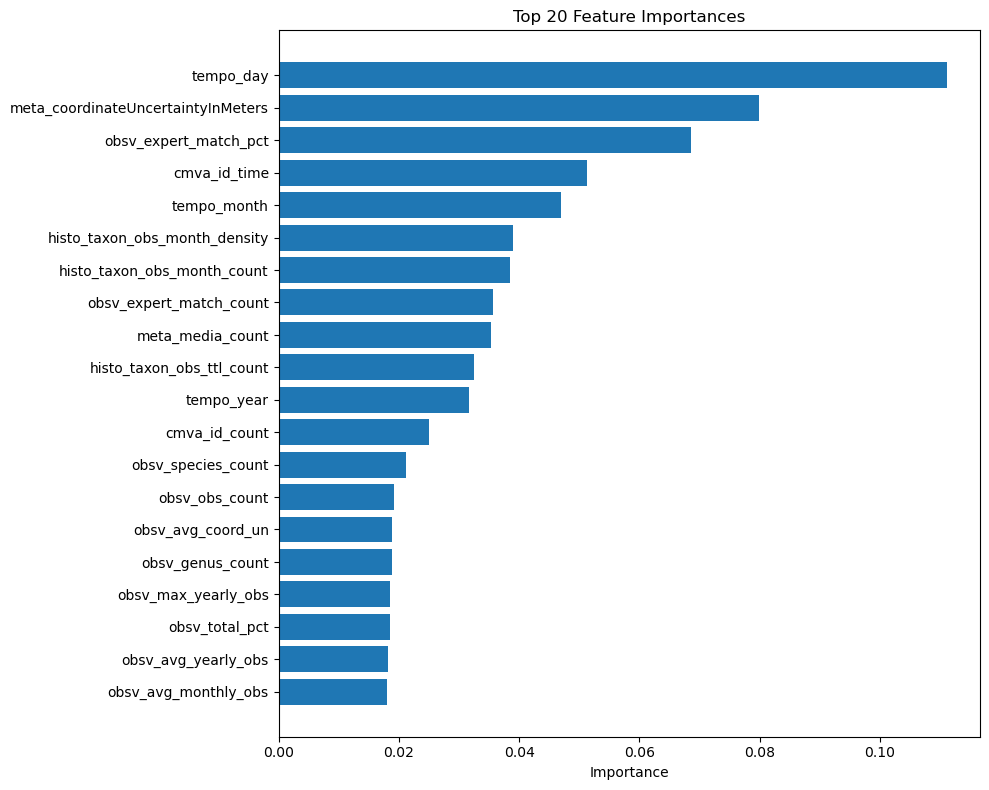


Top 10 Most Important Features:
tempo_day                     : 0.1111
meta_coordinateUncertaintyInMeters: 0.0799
obsv_expert_match_pct         : 0.0687
cmva_id_time                  : 0.0513
tempo_month                   : 0.0470
histo_taxon_obs_month_density : 0.0390
histo_taxon_obs_month_count   : 0.0385
obsv_expert_match_count       : 0.0357
meta_media_count              : 0.0353
histo_taxon_obs_ttl_count     : 0.0325


In [38]:
# 7. ANALYZE FEATURE IMPORTANCE

def plot_feature_importance(importance_df, top_n=20):
    """
    Visualize which features matter most.
    
    This tells you what the model learned.
    """
    top_features = importance_df.head(top_n)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print("="*60)
    for idx, row in top_features.head(10).iterrows():
        print(f"{row['feature']:30s}: {row['importance']:.4f}")


plot_feature_importance(feature_importance_df)